Using: cuda

=== Train Task 0 (classes 0–19) — OGD OFF (no basis yet) ===
[T0] Epoch 01: train_loss=2.7587 train_acc=0.176 | val_acc=0.212
[T0] Epoch 02: train_loss=2.5211 train_acc=0.261 | val_acc=0.249
[Eval] After Task 0 — T0 Val acc = 24.90%
[OGD] Basis size now: 2

=== Train Task 1 (classes 20–39) — OGD ON ===
[T1] Epoch 01: train_loss=2.7052 train_acc=0.186 | val_acc=0.253
[T1] Epoch 02: train_loss=2.5126 train_acc=0.243 | val_acc=0.265
[Eval] After Task 1 — T0 Val acc = 22.70%
[Eval] After Task 1 — T1 Val acc = 26.50%
[OGD] Basis size now: 4

=== Train Task 2 (classes 40–59) — OGD ON ===
[T2] Epoch 01: train_loss=2.6555 train_acc=0.202 | val_acc=0.227
[T2] Epoch 02: train_loss=2.4541 train_acc=0.263 | val_acc=0.236
[Eval] After Task 2 — T0 Val acc = 24.10%
[Eval] After Task 2 — T1 Val acc = 23.80%
[Eval] After Task 2 — T2 Val acc = 23.60%
[OGD] Basis size now: 6

=== Train Task 3 (classes 60–79) — OGD ON ===
[T3] Epoch 01: train_loss=2.6769 train_acc=0.197 | val_acc=0.212
[T3] E

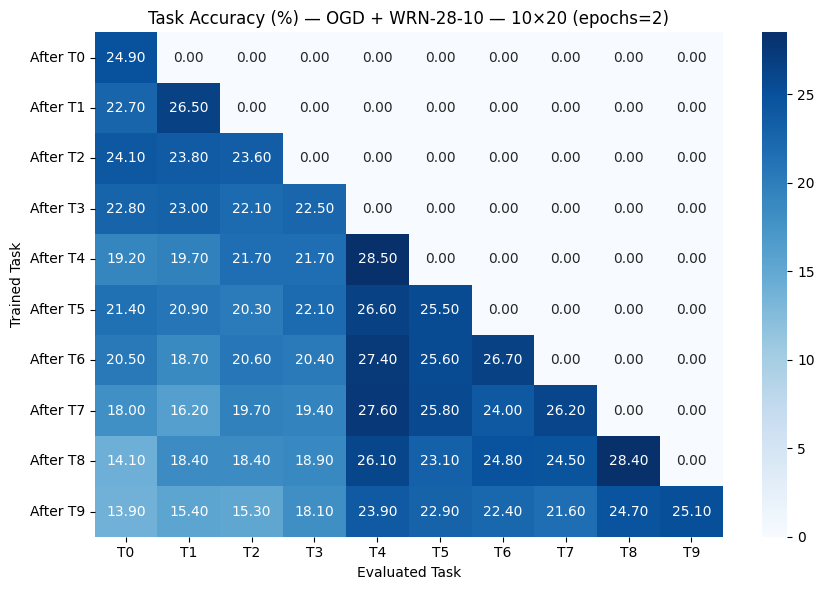

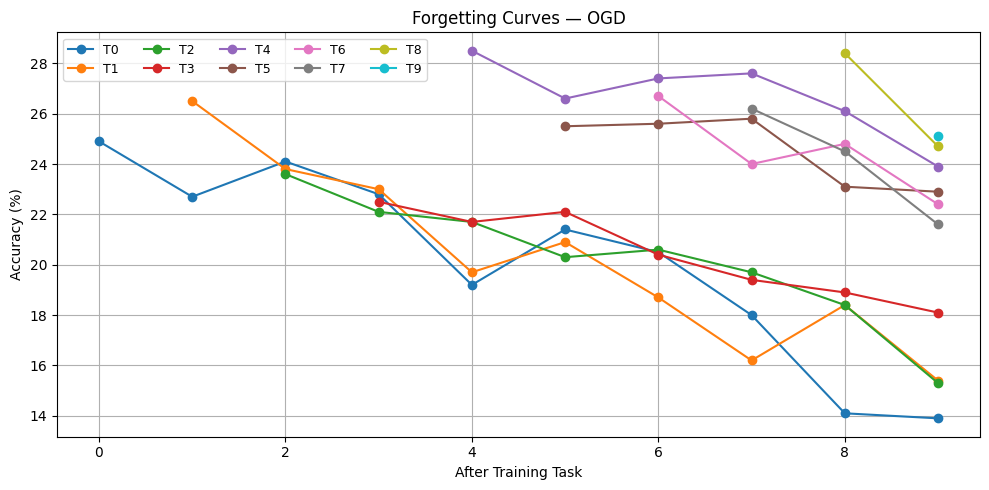

In [1]:
# =========================
# OGD on Split Tiny-ImageNet (10 tasks × 20 classes)
# Jupyter-ready, full 10×10 matrix + forgetting curves
# =========================

import os, math, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------
# Repro / Device
# -----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# -----------------------
# Where the dataset will live (auto-download if missing)
# -----------------------
import zipfile, urllib.request
DATA_ROOT = Path.home() / "data"
TIN_ROOT  = DATA_ROOT / "tiny-imagenet-200"
if not TIN_ROOT.exists():
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = DATA_ROOT / "tiny-imagenet-200.zip"
    if not zip_path.exists():
        print("⬇️  Downloading Tiny-ImageNet (~237MB)…")
        urllib.request.urlretrieve(url, zip_path)
        print("✅ Download complete")
    print("📦 Extracting…")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(DATA_ROOT)
    print("✅ Extracted to:", TIN_ROOT)

# -----------------------
# Class order & mapping (stable via wnids.txt)
# -----------------------
wnids_path = TIN_ROOT / "wnids.txt"
with open(wnids_path) as f:
    wnids = [w.strip() for w in f if w.strip()]
assert len(wnids) == 200
global_class_to_idx = {w:i for i,w in enumerate(wnids)}
TASKS = [list(range(t*20, (t+1)*20)) for t in range(10)]  # 10 tasks × 20 classes

# -----------------------
# Transforms
# -----------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4802,0.4481,0.3975), std=(0.2770,0.2691,0.2821)),
])
test_transform = transforms.Compose([
    transforms.Resize(64), transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4802,0.4481,0.3975), std=(0.2770,0.2691,0.2821)),
])

# -----------------------
# Minimal Tiny-ImageNet datasets
# -----------------------
class TinyImageNetTaskTrain(Dataset):
    def __init__(self, root: Path, class_indices, transform=None):
        self.root = root; self.transform = transform
        self.class_indices = class_indices
        self.wnids = [wnids[i] for i in class_indices]
        self.samples = []
        tr_root = self.root / "train"
        for gid, wn in zip(class_indices, self.wnids):
            img_dir = tr_root / wn / "images"
            for name in os.listdir(img_dir):
                if name.lower().endswith((".jpeg",".jpg",".png")):
                    self.samples.append((img_dir / name, gid))
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p, y = self.samples[i]
        x = Image.open(p).convert("RGB")
        if self.transform: x = self.transform(x)
        return x, y

class TinyImageNetTaskVal(Dataset):
    def __init__(self, root: Path, class_indices, transform=None):
        self.root = root; self.transform = transform
        self.class_set = set(class_indices)
        self.samples = []
        img_dir = self.root / "val" / "images"
        ann = self.root / "val" / "val_annotations.txt"
        with open(ann) as f:
            for line in f:
                parts = line.strip().split("\t")
                if len(parts) >= 2:
                    fname, wn = parts[0], parts[1]
                    gid = global_class_to_idx[wn]
                    if gid in self.class_set:
                        self.samples.append((img_dir / fname, gid))
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p, y = self.samples[i]
        x = Image.open(p).convert("RGB")
        if self.transform: x = self.transform(x)
        return x, y

def make_loaders_for_classes(cls_list, batch_size=128, workers=0):
    tr = TinyImageNetTaskTrain(TIN_ROOT, cls_list, transform=train_transform)
    va = TinyImageNetTaskVal(TIN_ROOT, cls_list, transform=test_transform)
    trl = DataLoader(tr, batch_size=batch_size, shuffle=True,  num_workers=workers, pin_memory=True)
    val = DataLoader(va, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)
    return trl, val, tr  # return train dataset too (for memory sampling)

# -----------------------
# WRN-28-10 (CIFAR-style with adaptive pool)
# -----------------------
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super().__init__()
        self.equalInOut = (in_planes == out_planes)
        self.bn1 = nn.BatchNorm2d(in_planes); self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes); self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.drop = dropRate
        self.short = None if self.equalInOut else nn.Conv2d(in_planes, out_planes, 1, stride, 0, bias=False)
    def forward(self, x):
        out = self.relu1(self.bn1(x)); out = self.conv1(out)
        out = self.relu2(self.bn2(out)); 
        if self.drop>0: out = F.dropout(out, p=self.drop, training=self.training)
        out = self.conv2(out)
        return (x if self.equalInOut else self.short(x)) + out

class NetworkBlock(nn.Module):
    def __init__(self, n, in_planes, out_planes, block, stride, dropRate=0.0):
        super().__init__()
        self.layer = nn.Sequential(*[
            block(in_planes if i==0 else out_planes, out_planes, stride if i==0 else 1, dropRate)
            for i in range(n)
        ])
    def forward(self, x): return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth=28, widen_factor=10, num_classes=200, dropRate=0.0):
        super().__init__()
        assert (depth-4)%6==0
        n=(depth-4)//6; k=widen_factor
        ch=[16,16*k,32*k,64*k]
        self.conv1 = nn.Conv2d(3,ch[0],3,1,1,bias=False)
        self.block1 = NetworkBlock(n,ch[0],ch[1],BasicBlock,1,dropRate)
        self.block2 = NetworkBlock(n,ch[1],ch[2],BasicBlock,2,dropRate)
        self.block3 = NetworkBlock(n,ch[2],ch[3],BasicBlock,2,dropRate)
        self.bn = nn.BatchNorm2d(ch[3]); self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(ch[3], num_classes); self.nC=ch[3]
        for m in self.modules():
            if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d): nn.init.constant_(m.weight,1.0); nn.init.constant_(m.bias,0.0)
            elif isinstance(m, nn.Linear): nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5)); nn.init.constant_(m.bias,0.0)
    def forward(self, x):
        x=self.conv1(x); x=self.block1(x); x=self.block2(x); x=self.block3(x)
        x=self.relu(self.bn(x)); x=F.adaptive_avg_pool2d(x,1).view(-1,self.nC)
        return self.fc(x)

# -----------------------
# Masked CE / Accuracy (task-aware, single 200-way head)
# -----------------------
def masked_cross_entropy(logits, labels, class_list):
    idx = {c:i for i,c in enumerate(class_list)}
    y  = torch.tensor([idx[int(l.item())] for l in labels], device=labels.device)
    mask = torch.tensor(class_list, device=logits.device)
    return F.cross_entropy(logits.index_select(1, mask), y)

@torch.no_grad()
def masked_accuracy(logits, labels, class_list):
    idx = {c:i for i,c in enumerate(class_list)}
    y  = torch.tensor([idx[int(l.item())] for l in labels], device=labels.device)
    mask = torch.tensor(class_list, device=logits.device)
    preds = logits.index_select(1, mask).argmax(1)
    return (preds==y).float().mean().item()*100.0

# -----------------------
# OGD: store gradient basis from past tasks & project new grads
# -----------------------
class OGD:
    """
    Stores an orthonormal basis of important gradient directions (across params).
    During training, projects current gradient onto the orthogonal complement.
    """
    def __init__(self, max_directions=2000, eps=1e-10):
        self.basis = []            # list of 1D tensors (flattened, L2-normalized)
        self.max_directions = max_directions
        self.eps = eps

    def add_vector(self, g_vec):
        # Normalize
        n = torch.norm(g_vec)
        if not torch.isfinite(n) or n < self.eps: 
            return
        v = g_vec / (n + self.eps)
        # Gram–Schmidt against existing basis
        for b in self.basis:
            v = v - torch.dot(v, b) * b
        n2 = torch.norm(v)
        if n2 > 1e-3:  # accept only if sufficiently new
            v = v / (n2 + self.eps)
            if len(self.basis) < self.max_directions:
                self.basis.append(v.detach())
            # else: drop (simple budget; could replace with FIFO or importance)

    def project_grad(self, g_vec):
        if not self.basis:
            return g_vec
        v = g_vec
        for b in self.basis:
            v = v - torch.dot(v, b) * b
        return v

# ---- helpers to flatten/unflatten grads
def params_vector(model):
    vec = []
    shapes = []
    for p in model.parameters():
        if p.requires_grad:
            vec.append(p.view(-1))
            shapes.append(p.shape)
    return torch.cat(vec), shapes

def grads_to_vector(model):
    vecs = []
    for p in model.parameters():
        if p.requires_grad:
            if p.grad is None:
                vecs.append(torch.zeros_like(p).view(-1))
            else:
                vecs.append(p.grad.view(-1))
    return torch.cat(vecs)

def vector_to_grads(model, vec):
    offset = 0
    for p in model.parameters():
        if p.requires_grad:
            n = p.numel()
            g = vec[offset:offset+n].view_as(p)
            if p.grad is None:
                p.grad = g.clone()
            else:
                p.grad.copy_(g)
            offset += n

# -----------------------
# Build OGD memory: few samples per class for each finished task
# -----------------------
def build_memory_indices(dataset, class_list, samples_per_class=5):
    # dataset.samples -> (path, global_label)
    per_cls = {c: [] for c in class_list}
    # simple pass to collect indices
    for i, (_, y) in enumerate(dataset.samples):
        if y in per_cls and len(per_cls[y]) < samples_per_class:
            per_cls[y].append(i)
        if all(len(v) >= samples_per_class for v in per_cls.values()):
            break
    idxs = [i for v in per_cls.values() for i in v]
    return idxs

def make_memory_loader(dataset, idxs, batch_size=64):
    mem_subset = Subset(dataset, idxs)
    return DataLoader(mem_subset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# -----------------------
# Compute gradient directions on memory to expand OGD basis
# -----------------------
def update_ogd_basis(model, ogd, mem_loader, class_list):
    model.eval()
    for x,y in mem_loader:
        x,y = x.to(device), y.to(device)
        model.zero_grad(set_to_none=True)
        logits = model(x)
        loss = masked_cross_entropy(logits, y, class_list)
        if not torch.isfinite(loss): 
            continue
        loss.backward()
        g = grads_to_vector(model).detach()
        if torch.isfinite(g).all():
            ogd.add_vector(g)

# -----------------------
# Train / Eval with OGD projection
# -----------------------
def train_task_ogd(model, loader, vloader, class_list, ogd, epochs=3, lr=0.1, wd=5e-4, prefix=""):
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd, nesterov=True)
    use_amp = (device.type=="cuda")
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

    for ep in range(1, epochs+1):
        model.train()
        seen=0; sum_loss=0.0; sum_acc=0.0
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=use_amp):
                logits = model(x)
                ce = masked_cross_entropy(logits, y, class_list)
                loss = ce  # no explicit reg; OGD will alter the gradient itself
            if not torch.isfinite(loss): continue
            scaler.scale(loss).backward()

            # ---- OGD projection (operate in full param vector space)
            scaler.unscale_(opt)  # ensure grads are in fp32
            g = grads_to_vector(model)
            if torch.isfinite(g).all() and ogd is not None and len(ogd.basis)>0:
                g_proj = ogd.project_grad(g)
                vector_to_grads(model, g_proj)

            # Optional safety: clip
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

            scaler.step(opt); scaler.update()

            bs = y.size(0); seen += bs
            sum_loss += loss.item()*bs
            sum_acc  += masked_accuracy(logits.detach(), y, class_list)*bs/100.0

        val = evaluate_task(model, vloader, class_list)
        print(f"{prefix}Epoch {ep:02d}: train_loss={sum_loss/max(1,seen):.4f} "
              f"train_acc={sum_acc/max(1,seen):.3f} | val_acc={val:.3f}")

@torch.no_grad()
def evaluate_task(model, loader, class_list):
    model.eval(); s=0.0; n=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        s += masked_accuracy(logits, y, class_list)*y.size(0)/100.0
        n += y.size(0)
    return s/max(1,n)

# -----------------------
# Orchestrate 10 tasks with OGD
# -----------------------
BATCH_SIZE          = 32
WORKERS             = 0
EPOCHS_PER_TASK     = 2        # 3–5 per your spec
LR                  = 0.001
WD                  = 5e-4
MEM_PER_CLASS       = 5        # memory size per class to build basis
OGD_MAX_DIRECTIONS  = 2000     # cap on basis size
MEM_BATCH           = 64

# Build loaders and keep raw train datasets (for memory sampling)
train_loaders, val_loaders, train_datasets = [], [], []
for t, cls_list in enumerate(TASKS):
    trl, val, trds = make_loaders_for_classes(cls_list, batch_size=BATCH_SIZE, workers=WORKERS)
    train_loaders.append(trl); val_loaders.append(val); train_datasets.append(trds)

model = WideResNet(depth=28, widen_factor=10, num_classes=200).to(device)
ogd   = OGD(max_directions=OGD_MAX_DIRECTIONS)

T = len(TASKS)
acc_matrix = np.zeros((T, T), dtype=np.float32)

def eval_on(k):
    return evaluate_task(model, val_loaders[k], TASKS[k]) * 100.0

for t in range(T):
    print(f"\n=== Train Task {t} (classes {TASKS[t][0]}–{TASKS[t][-1]}) "
          f"{'— OGD OFF (no basis yet)' if t==0 and len(ogd.basis)==0 else '— OGD ON'} ===")

    # Train with current OGD basis
    train_task_ogd(model, train_loaders[t], val_loaders[t], TASKS[t],
                   ogd=ogd, epochs=EPOCHS_PER_TASK, lr=LR, wd=WD, prefix=f"[T{t}] ")

    # Eval on all seen tasks 0..t
    for k in range(t+1):
        acc = eval_on(k)
        acc_matrix[t,k] = acc
        print(f"[Eval] After Task {t} — T{k} Val acc = {acc:.2f}%")

    # ---- Build/expand OGD basis using a tiny memory from the just-finished task
    mem_idxs = build_memory_indices(train_datasets[t], TASKS[t], samples_per_class=MEM_PER_CLASS)
    mem_loader = make_memory_loader(train_datasets[t], mem_idxs, batch_size=MEM_BATCH)
    update_ogd_basis(model, ogd, mem_loader, TASKS[t])
    print(f"[OGD] Basis size now: {len(ogd.basis)}")

# -----------------------
# Snapshot & plots
# -----------------------
print("\n=== Retention snapshot (diagonal = last-task accuracies) ===")
for r in range(T):
    row = "  ".join(f"{acc_matrix[r,c]:5.2f}" if acc_matrix[r,c]>0 else "  --- " for c in range(T))
    print(f"After T{r}: {row}")

plt.figure(figsize=(9,6))
sns.heatmap(acc_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f"T{i}" for i in range(T)],
            yticklabels=[f"After T{i}" for i in range(T)])
plt.xlabel("Evaluated Task"); plt.ylabel("Trained Task")
plt.title(f"Task Accuracy (%) — OGD + WRN-28-10 — 10×20 (epochs={EPOCHS_PER_TASK})")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
for k in range(T):
    curve = [acc_matrix[r,k] if r>=k else np.nan for r in range(T)]
    plt.plot(curve, marker='o', label=f"T{k}")
plt.xlabel("After Training Task"); plt.ylabel("Accuracy (%)")
plt.title("Forgetting Curves — OGD")
plt.grid(True); plt.legend(ncol=5, fontsize=9); plt.tight_layout(); plt.show()
